In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import torch.nn.functional as F
!pip install ipython-autotime
%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 2.31 s (started: 2024-09-19 18:46:11 +00:00)


Data Preparation

In [14]:
!pip install datasets transformers

from datasets import load_dataset

# Dataset: https://huggingface.co/datasets/celsowm/bbc_news_ptbr_summary
ds = load_dataset("celsowm/bbc_news_ptbr_summary")
corpus = ds['train']['texto']
corpus = corpus[:100]


time: 5.63 s (started: 2024-09-19 18:46:14 +00:00)


In [15]:
corpus[0]

'Era só mais um exame oftalmológico de rotina: "A!", "F!", "W!", repetia o paciente, enquanto tentava enxergar letras cada vez menores. Ao receber o resultado impresso de suas taxas de miopia e astigmatismo, porém, os olhos do paciente saltaram: "Fora Dilma", dizia em letras maiúsculas um trecho do laudo médico. O caso aconteceu na segunda semana de setembro, dentro da clínica de olhos da Santa Casa de Misericórdia de Belo Horizonte - hospital cujo atendimento é 100% vinculado ao SUS. Após a eclosão da história, descoberta pelo jornal mineiro O Tempo, a entidade divulgou uma carta pública, pedindo desculpas à presidente e candidata à reeleição pelo PT Dilma Rousseff, e anunciou abertura de sindicância para investigar o que considerou um "ato de sabotagem" contra a instituição. As investigações sobre o caso continuam, mas fontes ouvidas pela BBC Brasil afirmaram que dificilmente o responsável será identificado, já que a máquina utilizada para imprimir os resultados dos exames é manusead

time: 2.76 ms (started: 2024-09-19 18:46:19 +00:00)


Tokenization

In [16]:
# Convert sentences to words
def tokenize_corpus(corpus):
    tokens = [sentence.lower().split() for sentence in corpus]
    return tokens

tokens = tokenize_corpus(corpus)


time: 18.6 ms (started: 2024-09-19 18:46:19 +00:00)


Build Vocabulary

In [17]:
# Build a word-to-index and index-to-word mapping
def build_vocab(tokens):
    word_counts = Counter([word for sentence in tokens for word in sentence])
    vocabulary = sorted(word_counts.keys())
    word2idx = {word: idx for idx, word in enumerate(vocabulary)}
    idx2word = {idx: word for word, idx in word2idx.items()}
    return word2idx, idx2word

word2idx, idx2word = build_vocab(tokens)
vocab_size = len(word2idx)


time: 27.8 ms (started: 2024-09-19 18:46:19 +00:00)


Generate Training Data

In [18]:
# Parameters
window_size = 2  # Context window size

# Generate training data
def generate_training_data(tokens, word2idx, window_size):
    idx_pairs = []
    for sentence in tokens:
        indices = [word2idx[word] for word in sentence]
        for center_pos in range(len(indices)):
            for w in range(-window_size, window_size + 1):
                context_pos = center_pos + w
                if context_pos < 0 or context_pos >= len(indices) or center_pos == context_pos:
                    continue
                idx_pairs.append((indices[center_pos], indices[context_pos]))
    return np.array(idx_pairs)

idx_pairs = generate_training_data(tokens, word2idx, window_size)


time: 279 ms (started: 2024-09-19 18:46:19 +00:00)


Define the Skip-Gram Model

In [19]:
class Word2Vec(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(Word2Vec, self).__init__()
        self.embedding_dim = embedding_dim

        # Embedding for input words (target words)
        self.in_embed = nn.Embedding(vocab_size, embedding_dim)
        # Embedding for output words (context words)
        self.out_embed = nn.Embedding(vocab_size, embedding_dim)

    def forward(self, input_words, context_words):
        input_embedding = self.in_embed(input_words)
        context_embedding = self.out_embed(context_words)
        scores = torch.mul(input_embedding, context_embedding)
        scores = torch.sum(scores, dim=1)
        log_probs = F.logsigmoid(scores)  # Use F.logsigmoid instead of torch.logsigmoid
        loss = -log_probs
        return loss.mean()

    def input_embeddings(self):
        return self.in_embed.weight.detach().cpu().numpy()

time: 795 µs (started: 2024-09-19 18:46:20 +00:00)


Training the Model

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
embedding_dim = 100
num_epochs = 5
learning_rate = 0.01
batch_size = 32 # add batch size

model = Word2Vec(vocab_size, embedding_dim).to(device)
# Use the Adam optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


time: 31.2 ms (started: 2024-09-19 18:46:20 +00:00)


In [21]:
# Training Loop
for epoch in range(num_epochs):
    total_loss = 0
    np.random.shuffle(idx_pairs)
    for i in range(0, len(idx_pairs), batch_size):
        batch = idx_pairs[i:i+batch_size]
        center_words = torch.LongTensor(batch[:, 0]).to(device) # Move center_words to device
        context_words = torch.LongTensor(batch[:, 1]).to(device) # Move context_words to device

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        loss = model(center_words, context_words)

        # Backward pass
        loss.backward()

        # Update parameters
        optimizer.step()

        total_loss += loss.item()
    print(f'Epoch: {epoch+1}, Loss: {total_loss/len(idx_pairs):.4f}')

Epoch: 1, Loss: 0.0379
Epoch: 2, Loss: 0.0002
Epoch: 3, Loss: 0.0000
Epoch: 4, Loss: 0.0000
Epoch: 5, Loss: 0.0000
time: 1min 5s (started: 2024-09-19 18:46:20 +00:00)


 Visualize the Embeddings

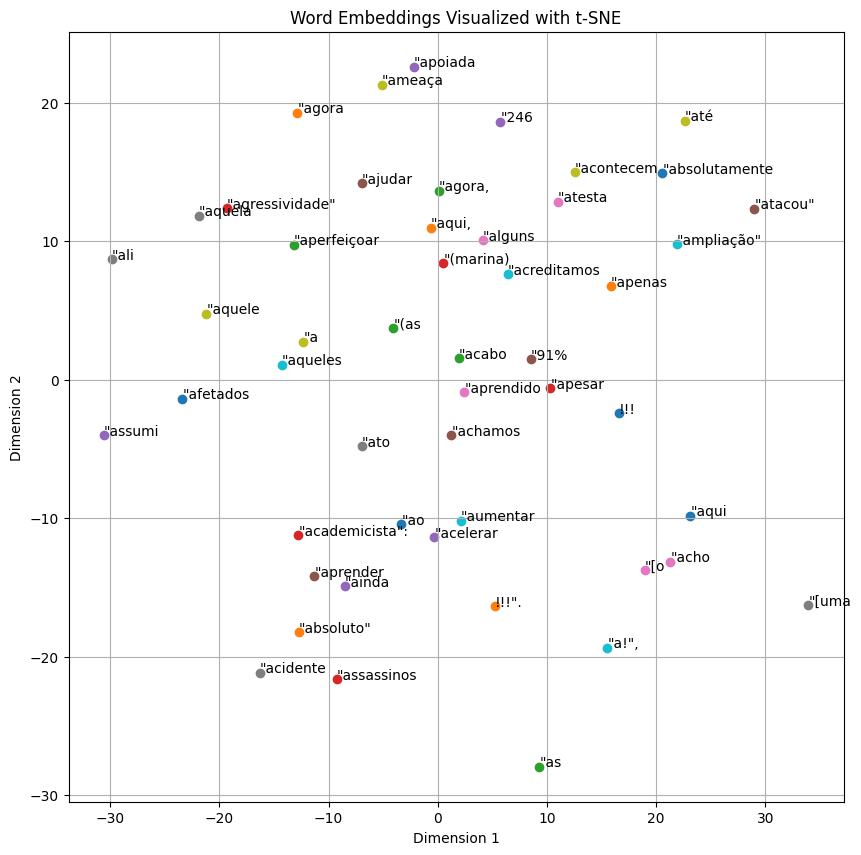

time: 999 ms (started: 2024-09-19 18:47:25 +00:00)


In [22]:
# Get embeddings
embeddings = model.input_embeddings()

# Select the first 50 elements of input_embedding
embeddings_50 = embeddings[:100]

# Use t-SNE to reduce dimensions to 2D
tsne = TSNE(n_components=2, perplexity=5, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings_50)

# Plotting
plt.figure(figsize=(10, 10))
for idx, word in enumerate(idx2word.values()):
    if idx >= 50:
        break
    plt.scatter(embeddings_2d[idx, 0], embeddings_2d[idx, 1])
    plt.annotate(word, (embeddings_2d[idx, 0], embeddings_2d[idx, 1]))
plt.title('Word Embeddings Visualized with t-SNE')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.grid(True)
plt.show()